In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.lines as mlines


import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps
import animate

# Parameter setting

Plot formatting

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

Saving

In [3]:
plot_dir = '../plots/2023-03-29_figures'
save = True

Names

In [4]:
name_catalog = '\emph{{Gaia}} Cosmological Quasar Catalog'
abbrv_catalog = 'GaiaQ'

name_gpurer = '\emph{{Gaia}} Purer Sample'
abbrv_gpurer = '\emph{{Gaia}} Purer'

Plotting variables

In [5]:
cmap_map = 'plasma'
cmap_blues = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, midpoint=0.6, stop=1.0, name='Blues_shifted')
cmap_hist = 'inferno_r'

color_gaia = 'purple'

Functions

In [6]:
def get_ndens_map(ras, decs, NSIDE=64):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

Map settings

In [7]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [8]:
G_hi = 20.5
G_lo = 20.0

In [9]:
rng = np.random.default_rng(seed=42)

# Load datasets

### Gaia

In [10]:
fn_gall = '../data/gaia_candidates.fits.gz'
tab_gall = utils.load_table(fn_gall)
print(len(tab_gall))

6649162


In [11]:
fn_gpurer_ids = '../data/gaia_purer_sourceids.fits'
tab_gpurer_ids = utils.load_table(fn_gpurer_ids)
tab_gpurer = join(tab_gall, tab_gpurer_ids, keys='source_id', join_type='inner', metadata_conflicts='silent')
print(len(tab_gpurer))

1942825


In [12]:
fn_gsup = '../data/gaia_candidates_superset.fits'
tab_gsup = utils.load_table(fn_gsup)
print(len(tab_gsup))

1518782


In [13]:
fn_gclean = '../data/gaia_candidates_clean.fits'
tab_gclean = utils.load_table(fn_gclean)
print(len(tab_gclean))

1442077


In [14]:
fn_gcatlo = f'../data/gaiaQ_G{G_lo}.fits'
tab_gcatlo = utils.load_table(fn_gcatlo)
print(len(tab_gcatlo))

767866


In [15]:
fn_gcathi = f'../data/gaiaQ_G{G_hi}.fits'
tab_gcathi = utils.load_table(fn_gcathi)
print(len(tab_gcathi))

1318566


### SDSS

These are SDSS objects that have (any) Gaia source matches. There is unWISE data where available, but the below catalogs are not limited to unWISE matches.

In [16]:
tab_squasars = utils.load_table(f'../data/quasars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS quasars: {len(tab_squasars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_squasars['mag_w1_vg']) & ~tab_squasars.mask['mag_w1_vg']))

Number of SDSS quasars: 379698
Number with unWISE info: 350070


In [17]:
tab_sstars = utils.load_table(f'../data/stars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS stars: {len(tab_sstars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sstars['mag_w1_vg']) & ~tab_sstars.mask['mag_w1_vg']))

Number of SDSS stars: 683221
Number with unWISE info: 482080


In [18]:
tab_sgals = utils.load_table(f'../data/galaxies_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS galaxies: {len(tab_sgals)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sgals['mag_w1_vg']) & ~tab_sgals.mask['mag_w1_vg']))

Number of SDSS galaxies: 717059
Number with unWISE info: 600897


Only objects in superset (gaia qso candidates with unWISE data and QSOC redshifts and G lim)

In [19]:
fn_labeled_sup = '../data/labeled_superset.fits'
tab_labeled_sup = utils.load_table(fn_labeled_sup)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled_sup)}")

Number of labeled Gaia quasar candidates for training/validation: 249714


# Figures

### Purer map

TODO: should i limit to having QSOC redshifts here? (now just do G lim)

TODO: healpy / matplotlib error with show_tickmarkers=True

In [78]:
map_gpurer = get_ndens_map(tab_gpurer['ra'], tab_gpurer['dec'], NSIDE=NSIDE)

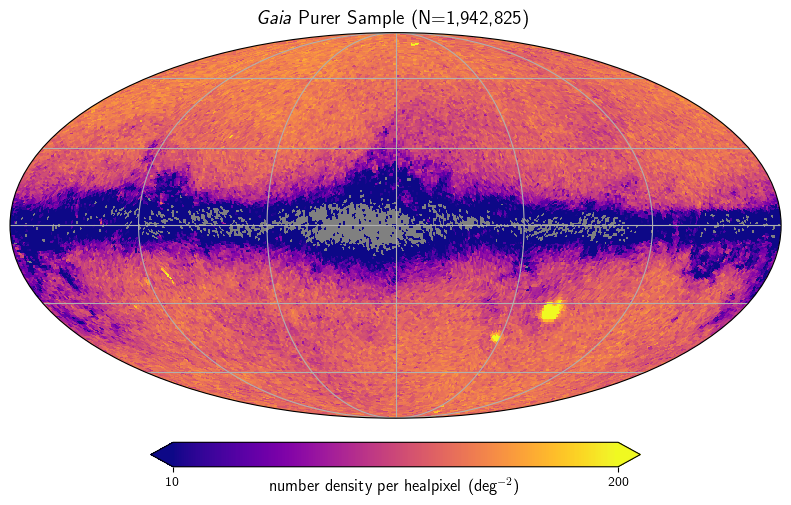

In [79]:
projview(map_gpurer, title=rf"{name_gpurer} (N={len(tab_gpurer):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=200, norm='log', graticule=True,
            #show_tickmarkers=True
        )

fn = f'{plot_dir}/gpurer_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Fractional matrix

In [22]:
tab_squasars_all = utils.load_table('../data/sdss_quasars_specobj.csv', format='csv')
tab_squasars_xgaia = utils.load_table('../data/quasars_sdss_xgaia.csv', format='csv')
print(tab_squasars_all.columns)
print(tab_squasars_xgaia.columns)

<TableColumns names=('specObjID','ra','dec')>
<TableColumns names=('ra','dec','source_id','ra_sdss','dec_sdss','objid','z','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_n_obs','phot_rp_n_obs')>


In [23]:
# tab_squasars_xgaia.keep_columns()
# tab_squasars_xgaia_all = join(tab_squasars_all, tab_squasars_xgaia, keys='specObjID')

Hum looks like i didnt save the specObjID.... will need to figure out

In [24]:
tab_gqsoc = tab_gall[np.isfinite(tab_gall['redshift_qsoc'])]
print(len(tab_gqsoc))

6375063


In [25]:
tabs = [tab_gall, tab_gqsoc, tab_gpurer, tab_gsup, tab_gclean, tab_squasars_xgaia]
tab_names = ['\emph{Gaia} quasar candidates', 
             '\emph{Gaia} quasar candidates\nwith redshift estimates', 
             '\emph{Gaia} purer', 
             'GaiaQ superset', 
             'GaiaQ clean', 
             r'SDSS Quasars $\times$ Gaia']
N_tabs = len(tabs)

frac_matrix = np.empty((N_tabs, N_tabs))
for i in range(N_tabs):
    for j in range(N_tabs):
        i_iinj = np.isin(tabs[i]['source_id'], tabs[j]['source_id'])
        frac_matrix[i,j] = np.sum(i_iinj)/len(i_iinj)
        
frac_matrix = frac_matrix.T

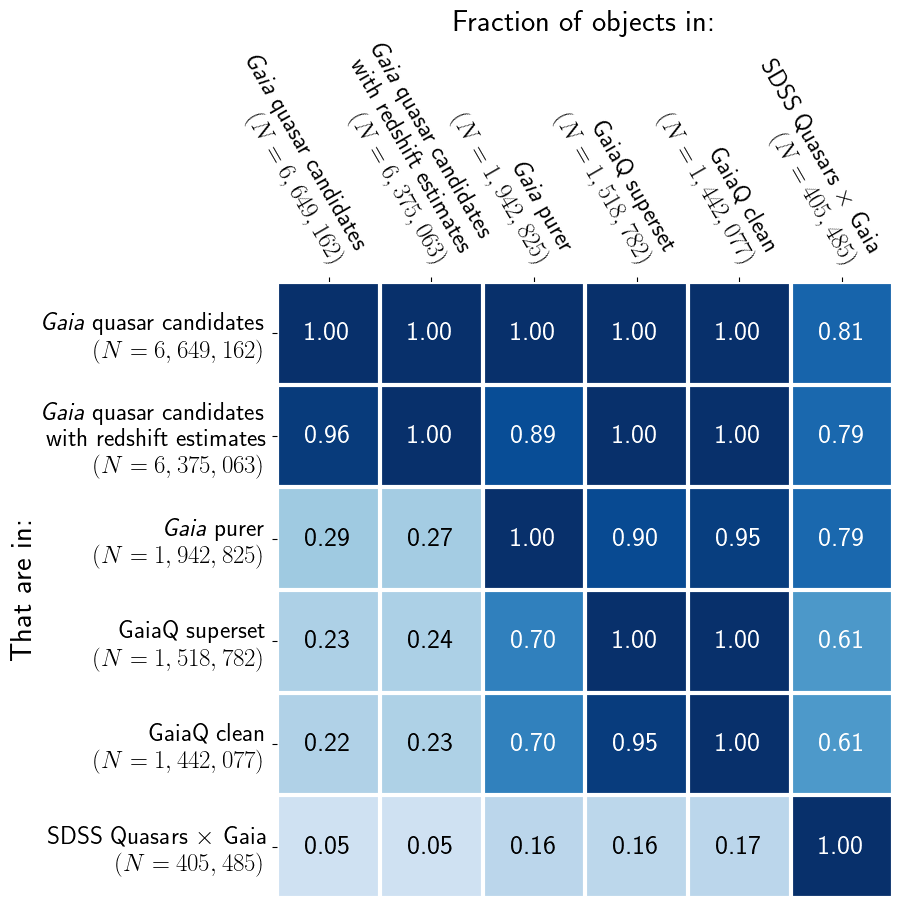

In [26]:
plt.figure(figsize=(8,8))
ax = plt.gca()
im = ax.imshow(frac_matrix, cmap=cmap_blues)

# Show all ticks and label them with the respective list entries
labels_withN = [f'{tab_names[i]}\n(N={len(tabs[i]):,})' for i in range(N_tabs)]
ax.set_xticks(np.arange(len(tab_names)), labels=labels_withN)
ax.set_yticks(np.arange(len(tab_names)), labels=labels_withN)
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-60, ha="right",
             rotation_mode="anchor")

ax.spines[:].set_visible(False)
ax.set_xticks(np.arange(frac_matrix.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(frac_matrix.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

# Loop over data dimensions and create text annotations.
for i in range(len(tab_names)):
    for j in range(len(tab_names)):
        color = 'w' if frac_matrix[i, j]>0.5 else 'k'
        text = ax.text(j, i, f"{frac_matrix[i, j]:.2f}",
                       ha="center", va="center", color=color, fontsize=20)
        
plt.title("Fraction of objects in:", fontsize=22)
plt.ylabel("That are in:", fontsize=22)

fn = f'{plot_dir}/frac_matrix.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: make non rectangular so can include WISE etc 

### Decontamination

In [27]:
def plot_cut(ax, cut, x_eq=None, y_eq=None, only_plot=None, only_axis=None,
             xlim=None, ylim=None):

    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    xx = np.array(xlim)
    yy = np.array(ylim)
    if only_plot=='above':
        if only_axis=='x':
            xx[0] = x_eq
        if only_axis=='y':
            yy[0] = y_eq
    if only_plot=='below':
        if only_axis=='x':
            xx[1] = x_eq
        if only_axis=='y':
            yy[1] = y_eq
            
            
    #ax.plot(xx, cut[0]*xx+cut[1], 'k-', lw=0.7)
    if abs(cut[0]) > abs(cut[1]):
        # solve ax+by=c for x: (c-by)/a
        xcut = (cut[2] - cut[1]*yy)/cut[0]
        ax.plot(xcut, yy, 'k-', lw=0.7)
    else:
        # solve ax+by=c for y: (c-ax)/b
        ycut = (cut[2] - cut[0]*xx)/cut[1]
        ax.plot(xx, ycut, 'k-', lw=0.7)

In [28]:
tag_decontam = '_mag0.1-0.01'
#tag_decontam = '_mag0.1'
fn_cuts = f'../data/color_cuts{tag_decontam}.txt'
color_names, cuts = np.genfromtxt(fn_cuts, dtype=['U15', '<f8'], unpack=True)

In [29]:
g_w1_lim = (-1, 9)
w1_w2_lim = (-1, 2)
bp_g_lim = (-4, 3)
g_rp_lim = (-1, 6)

In [30]:
tabs = [tab_squasars, tab_sstars, tab_sgals]

In [31]:
colors = ['blue', 'brown', 'orange']
labels = ['SDSS Quasars', 'SDSS Stars', 'SDSS Galaxies']
zorders = [1,2,3]

TODO: do we like bp_g vs g_rp, or should we do vs one of the other colors we cut on?

TODO: should i somehow show which side of the line we're taking?

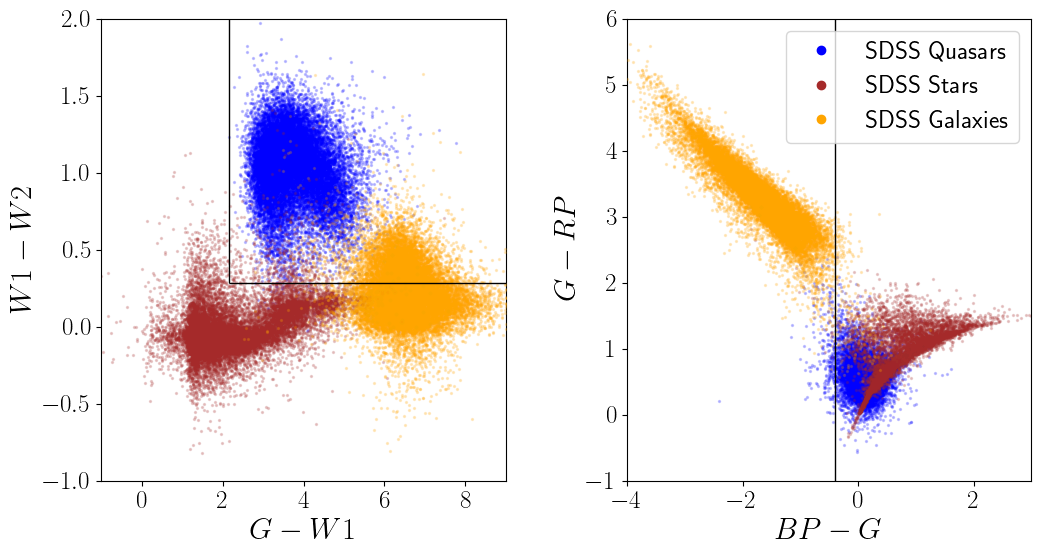

In [32]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0, ax1 = axarr
plt.subplots_adjust(wspace=0.3)

N_subsample = 20000
patches = []


for i in range(len(tabs)):
    tab = tabs[i]
    i_unwise = np.isfinite(tab['mag_w1_vg']) & np.isfinite(tab['mag_w2_vg'])
    i_subsample = rng.choice(np.arange(len(tab[i_unwise])), size=N_subsample, replace=False)
    tab_plot = tab[i_unwise][i_subsample]
    
        
    ax0.scatter(tab_plot['phot_g_mean_mag']-tab_plot['mag_w1_vg'], 
                tab_plot['mag_w1_vg']-tab_plot['mag_w2_vg'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
    
    ax1.scatter(tab_plot['phot_bp_mean_mag']-tab_plot['phot_g_mean_mag'], 
                tab_plot['phot_g_mean_mag']-tab_plot['phot_rp_mean_mag'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
                        
    patches.append( mlines.Line2D([], [], ls='None', color=colors[i], label=labels[i], marker='o'))

ax0.vlines(x=cuts[0], ymin=cuts[1], ymax=w1_w2_lim[1], linewidth=1, color='k', zorder=4)
ax0.hlines(y=cuts[1], xmin=cuts[0], xmax=g_w1_lim[1], linewidth=1, color='k', zorder=4)
ax1.axvline(cuts[2], linewidth=1, color='k', zorder=4)

ax1.legend(handles=patches, loc='upper right')

ax0.set_xlabel(r'$G-W1$')
ax0.set_ylabel(r'$W1-W2$')
ax0.set_xlim(g_w1_lim)
ax0.set_ylim(w1_w2_lim)

ax1.set_xlabel(r'$BP-G$')
ax1.set_ylabel(r'$G-RP$')
ax1.set_xlim(bp_g_lim)
ax1.set_ylim(g_rp_lim)

fn = f'{plot_dir}/color_color_sdss_all.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [33]:
tab_q = tab_labeled_sup[tab_labeled_sup['class']=='q']
tab_s = tab_labeled_sup[tab_labeled_sup['class']=='s']
tab_g = tab_labeled_sup[tab_labeled_sup['class']=='g']

In [34]:
tabs = [tab_s, tab_g]
colors = ['brown', 'orange']
labels = ['SDSS Stars', 'SDSS Galaxies']
zorders = [1,2]

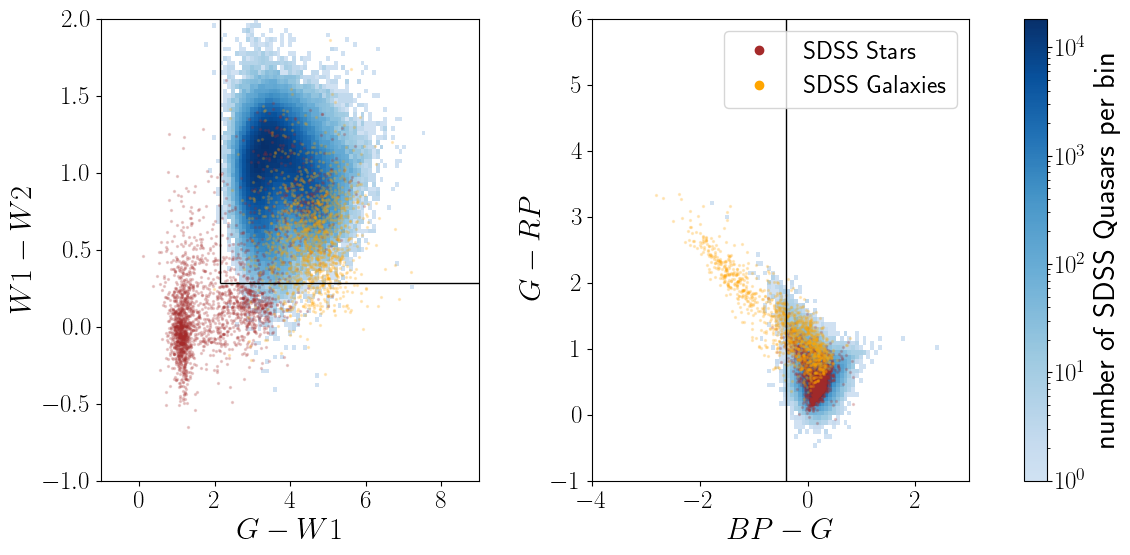

In [35]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ax0, ax1 = axarr
plt.subplots_adjust(wspace=0.3)

bins_g_w1 = np.linspace(*g_w1_lim, 100)
bins_w1_w2 = np.linspace(*w1_w2_lim, 100)

cmax = 5e4
g_w1 = np.array(tab_q['phot_g_mean_mag']-tab_q['mag_w1_vg'])
w1_w2 = np.array(tab_q['mag_w1_vg']-tab_q['mag_w2_vg'])
h = ax0.hist2d(g_w1, w1_w2, bins=(bins_g_w1, bins_w1_w2), cmin=1, cmax=cmax, cmap=cmap_blues, norm='log')

bins_bp_g = np.linspace(*bp_g_lim, 100)
bins_g_rp = np.linspace(*g_rp_lim, 100)

bp_g = np.array(tab_q['phot_bp_mean_mag']-tab_q['phot_g_mean_mag'])
g_rp = np.array(tab_q['phot_g_mean_mag']-tab_q['phot_rp_mean_mag'])
h = ax1.hist2d(bp_g, g_rp, bins=(bins_bp_g, bins_g_rp), cmin=1, cmax=cmax, cmap=cmap_blues, norm='log')

fig.colorbar(h[3], ax=axarr.ravel().tolist(), label='number of SDSS Quasars per bin')

patches = []
for i in range(len(tabs)):
    tab_plot = tabs[i]

    ax0.scatter(tab_plot['phot_g_mean_mag']-tab_plot['mag_w1_vg'], 
                tab_plot['mag_w1_vg']-tab_plot['mag_w2_vg'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
    
    ax1.scatter(tab_plot['phot_bp_mean_mag']-tab_plot['phot_g_mean_mag'], 
                tab_plot['phot_g_mean_mag']-tab_plot['phot_rp_mean_mag'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
                        
    patches.append( mlines.Line2D([], [], ls='None', color=colors[i], label=labels[i], marker='o'))

ax1.legend(handles=patches, loc='upper right')

ax0.vlines(x=cuts[0], ymin=cuts[1], ymax=w1_w2_lim[1], linewidth=1, color='k', zorder=4)
ax0.hlines(y=cuts[1], xmin=cuts[0], xmax=g_w1_lim[1], linewidth=1, color='k', zorder=4)
ax1.axvline(cuts[2], linewidth=1, color='k', zorder=4)

ax0.set_xlabel(r'$G-W1$')
ax0.set_ylabel(r'$W1-W2$')
ax0.set_xlim(g_w1_lim)
ax0.set_ylim(w1_w2_lim)

ax1.set_xlabel(r'$BP-G$')
ax1.set_ylabel(r'$G-RP$')
ax1.set_xlim(bp_g_lim)
ax1.set_ylim(g_rp_lim)

fn = f'{plot_dir}/color_color_sdss_labeled_sup.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

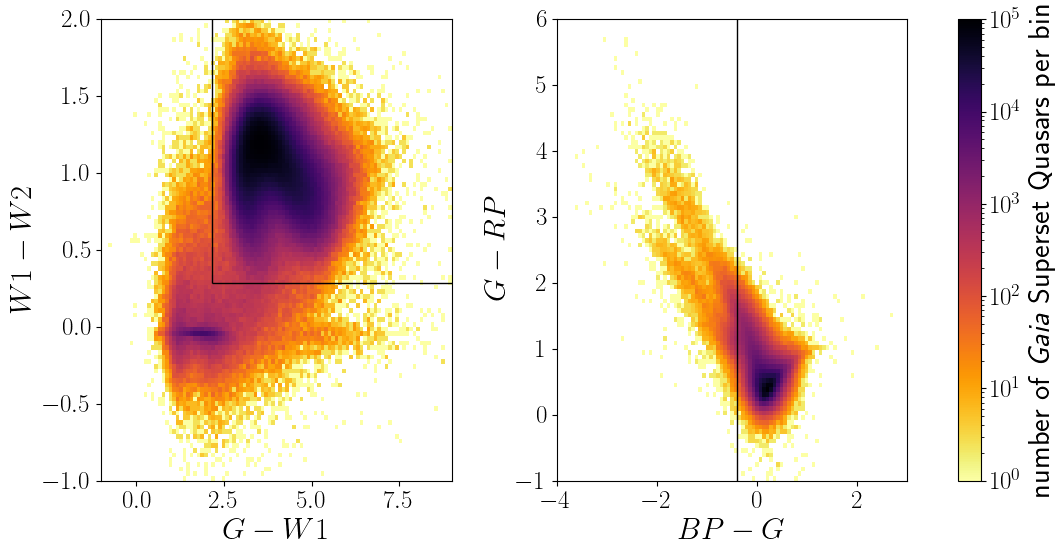

In [36]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
ax0, ax1 = axarr
plt.subplots_adjust(wspace=0.3)

bins_g_w1 = np.linspace(*g_w1_lim, 100)
bins_w1_w2 = np.linspace(*w1_w2_lim, 100)

g_w1 = np.array(tab_gsup['phot_g_mean_mag']-tab_gsup['mag_w1_vg'])
w1_w2 = np.array(tab_gsup['mag_w1_vg']-tab_gsup['mag_w2_vg'])
h = ax0.hist2d(g_w1, w1_w2, bins=(bins_g_w1, bins_w1_w2), cmin=1, cmap=cmap_hist, norm='log')

bins_bp_g = np.linspace(*bp_g_lim, 100)
bins_g_rp = np.linspace(*g_rp_lim, 100)

bp_g = np.array(tab_gsup['phot_bp_mean_mag']-tab_gsup['phot_g_mean_mag'])
g_rp = np.array(tab_gsup['phot_g_mean_mag']-tab_gsup['phot_rp_mean_mag'])
h = ax1.hist2d(bp_g, g_rp, bins=(bins_bp_g, bins_g_rp), cmin=1, cmap=cmap_hist, norm='log')

fig.colorbar(h[3], ax=axarr.ravel().tolist(), label=r'number of \emph{Gaia} Superset Quasars per bin')

ax0.vlines(x=cuts[0], ymin=cuts[1], ymax=w1_w2_lim[1], linewidth=1, color='k', zorder=4)
ax0.hlines(y=cuts[1], xmin=cuts[0], xmax=g_w1_lim[1], linewidth=1, color='k', zorder=4)
ax1.axvline(cuts[2], linewidth=1, color='k', zorder=4)

ax0.set_xlabel(r'$G-W1$')
ax0.set_ylabel(r'$W1-W2$')
ax0.set_xlim(g_w1_lim)
ax0.set_ylim(w1_w2_lim)

ax1.set_xlabel(r'$BP-G$')
ax1.set_ylabel(r'$G-RP$')
ax1.set_xlim(bp_g_lim)
ax1.set_ylim(g_rp_lim)

fn = f'{plot_dir}/color_color_gsup.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: light grey transparent background where excluding

## Redshift analysis vs SDSS

In [37]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K27_std'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 245308
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err','redshift_spz')>


TODO: Should i show these for all labeled and not just test? Looks much nicer when i do, but not entirely fair to include training set

In [38]:
rand_ints_labeled = tab_spz_labeled['rand_ints']
i_train, i_valid, i_test = utils.split_train_val_test(rand_ints_labeled,
                                 frac_train=0.7, frac_val=0.15, frac_test=0.15)

In [39]:
idx_Glo_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_lo

In [40]:
idx_Ghi_test = tab_spz_labeled['phot_g_mean_mag'][i_test] < G_hi

### Redshift estimates vs SDSS accuracy

In [41]:
z_sdss_test = tab_spz_labeled['z_sdss'][i_test]
z_spzraw_test = tab_spz_labeled['redshift_spz_raw'][i_test]
z_spz_test = tab_spz_labeled['redshift_spz'][i_test]
z_gaia_test = tab_spz_labeled['redshift_qsoc'][i_test]

In [42]:
z_bins = np.linspace(0, np.max(z_gaia_test), 200)

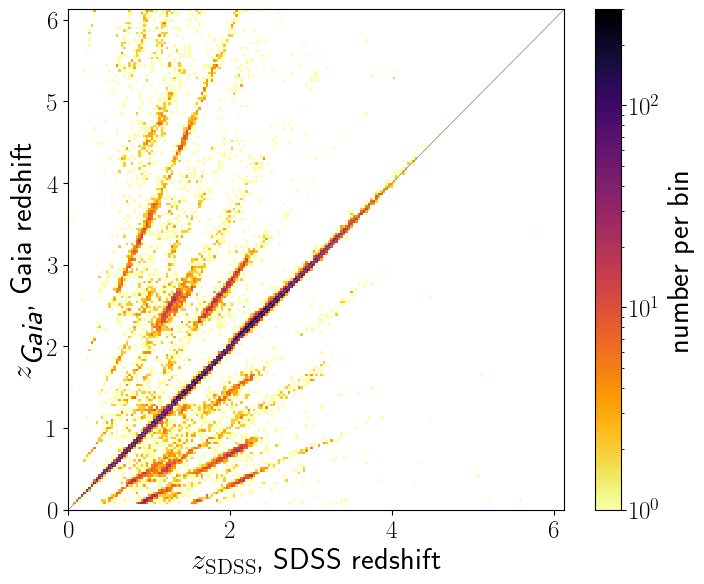

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_test[idx_Ghi_test], z_gaia_test[idx_Ghi_test], bins=z_bins, cmin=1, cmap=cmap_hist,
              norm=matplotlib.colors.LogNorm(vmax=3e2),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.plot(z_bins, z_bins, color='grey', lw=0.5)

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')

fn = f'{plot_dir}/redshift_zgaia_vs_zdss.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

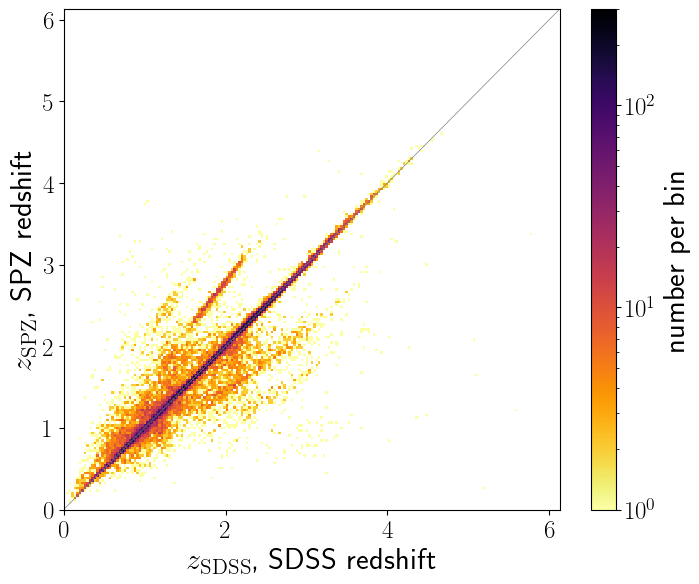

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_test[idx_Ghi_test], z_spz_test[idx_Ghi_test], bins=z_bins, cmin=1, cmap=cmap_hist,
              norm=matplotlib.colors.LogNorm(vmax=3e2),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.plot(z_bins, z_bins, color='grey', lw=0.5)

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{SPZ}$, SPZ redshift')

fn = f'{plot_dir}/redshift_zspz_vs_zdss.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### dz error cumulative histograms

In [45]:
dz_spzraw_test = (z_spzraw_test - z_sdss_test)/(1+z_sdss_test)
dz_spz_test = (z_spz_test - z_sdss_test)/(1+z_sdss_test)
dz_gaia_test = (z_gaia_test - z_sdss_test)/(1+z_sdss_test)

In [46]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)

TODO: it looks worse when we do the softening vs just the z=0.1 hard cut. better way to choose the min than im doing maybe?

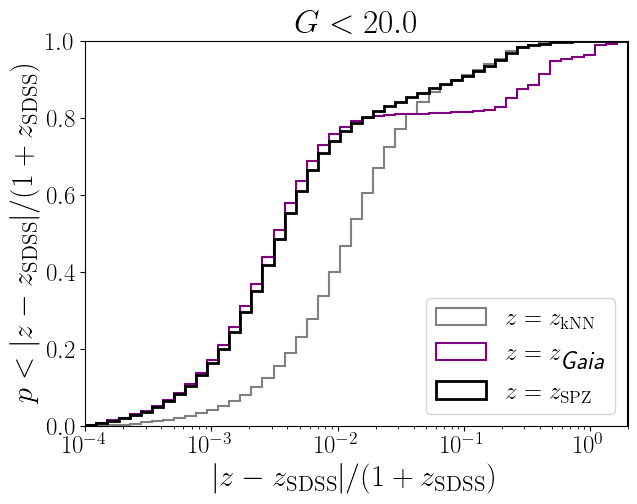

In [47]:
plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_lo}$', fontsize=24)
lw=1.5
plt.hist(abs(dz_spzraw_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='grey', label=r'$z=z_\mathrm{kNN}$')
plt.hist(abs(dz_gaia_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='purple', label=r'$z=z_\mathrm{\emph{Gaia}}$')
plt.hist(abs(dz_spz_test[idx_Glo_test]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2,
         color='k', label=r'$z=z_\mathrm{SPZ}$')
plt.xlabel(r'$|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.ylabel(r'$p < |z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

fn = f'{plot_dir}/redshift_error_cumulative_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Fraction of outliers as function of G

TODO why is this so different than earlier version??

[18.  18.1 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3
 19.4 19.5 19.6 19.7 19.8 19.9 20.  20.1 20.2 20.3 20.4 20.5]


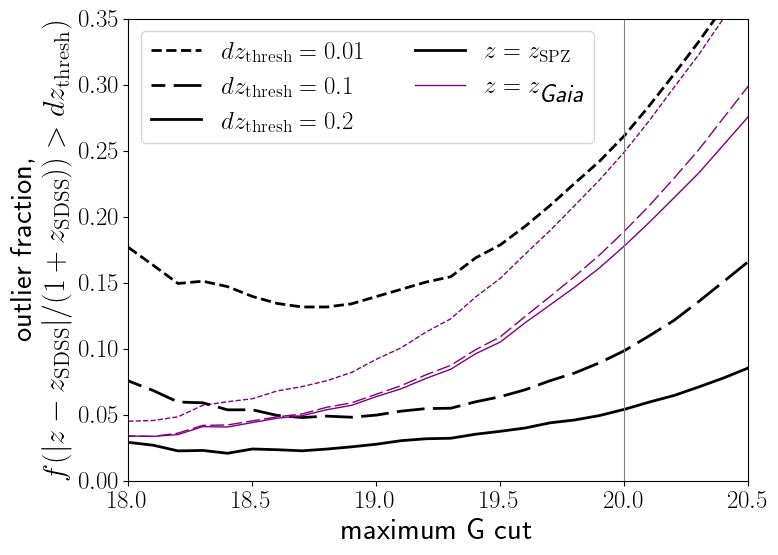

In [48]:
plt.figure(figsize=(8,6))
ax = plt.gca()

G_arr = tab_spz_labeled['phot_g_mean_mag'][i_test]
G_maxs = np.arange(18.0, 20.501, 0.1)
print(G_maxs)

dz_threshs = [0.01, 0.1, 0.2]
alphas = [0.4, 0.6, 0.8, 1]
lss = ['--', (5, (10,3)), '-']
for iz, dz_thresh in enumerate(dz_threshs):
    n_insample = np.empty(len(G_maxs), dtype=int)
    f_outliers_spz = np.empty(len(G_maxs))
    f_outliers_gaia = np.empty(len(G_maxs))

    for i in range(len(G_maxs)):
        i_insample = G_arr < G_maxs[i]
        n_insample[i] = np.sum(i_insample)
        
        f_outliers_spz[i] = np.sum(np.abs(dz_spz_test[i_insample]) > dz_thresh) / n_insample[i]
        f_outliers_gaia[i] = np.sum(np.abs(dz_gaia_test[i_insample]) > dz_thresh) / n_insample[i]
        
    plt.plot(G_maxs, f_outliers_spz, color='k', alpha=1, ls=lss[iz], lw=2, label=fr'$dz_\mathrm{{thresh}}={dz_thresh}$')
    plt.plot(G_maxs, f_outliers_gaia, color=color_gaia, alpha=1, ls=lss[iz], lw=1)

plt.xlabel("maximum G cut")
plt.ylabel('outlier fraction,\n' + r'$f(|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS}))>dz_\mathrm{{thresh}})$')
plt.ylim(0, 0.35)
plt.xlim(np.min(G_maxs), np.max(G_maxs))


handles, labels = ax.get_legend_handles_labels()
line_spz = Line2D([], [], color='k', lw=2)#, label='$z=z_\mathrm{SPZ/QSOC}$')
line_gaia = Line2D([], [], color=color_gaia, lw=1)#, label='$z=z_\mathrm{QSOC}$')
handles.extend([line_spz, line_gaia])
labels.extend(['$z=z_\mathrm{SPZ}$', '$z=z_\mathrm{\emph{Gaia}}$'])

plt.legend(handles, labels, ncol=2)

plt.axvline(20.0, color='grey', lw=0.8)

fn = f'{plot_dir}/redshift_outliers_vs_Gmax.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Selection function systematics maps

In [49]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print(NSIDE, NPIX)
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

64 49152
Area per pixel: 0.839 deg


In [50]:
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
map_dust = maps.get_dust_map(NSIDE=NSIDE, R=3.1, fn_map=fn_dustmap)

Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy


In [51]:
fn_starmap = f'../data/maps/map_stars_NSIDE{NSIDE}.npy'
map_stars = maps.get_star_map(NSIDE=NSIDE, fn_map=fn_starmap)
map_stardens = map_stars/area_per_pixel

Star map already exists, loading from ../data/maps/map_stars_NSIDE64.npy


In [52]:
fn_m10map = f'../data/maps/map_m10_NSIDE{NSIDE}.npy'
map_m10 = maps.get_m10_map(NSIDE=NSIDE, fn_map=fn_m10map)

M10 map already exists, loading from ../data/maps/map_m10_NSIDE64.npy


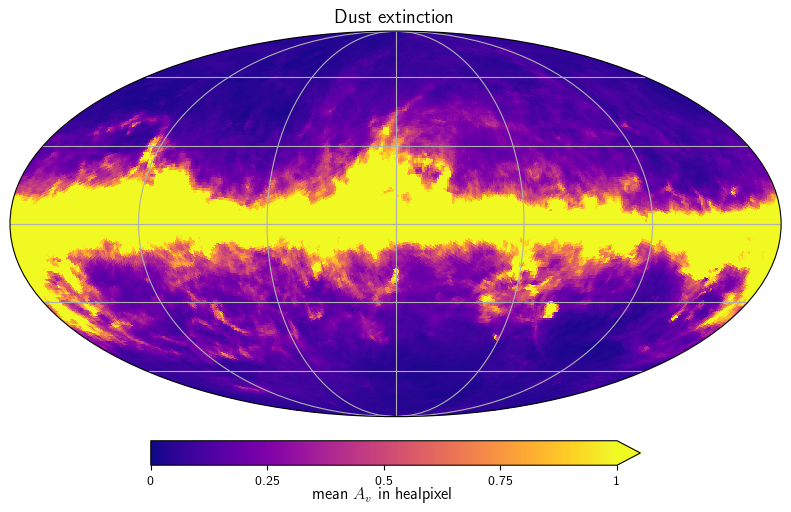

In [53]:
projview(map_dust, title=rf"Dust extinction",
         unit=r"mean $A_v$ in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=0.0, max=1.0, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
         graticule=True)

fn = f'{plot_dir}/systematics_map_dust.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

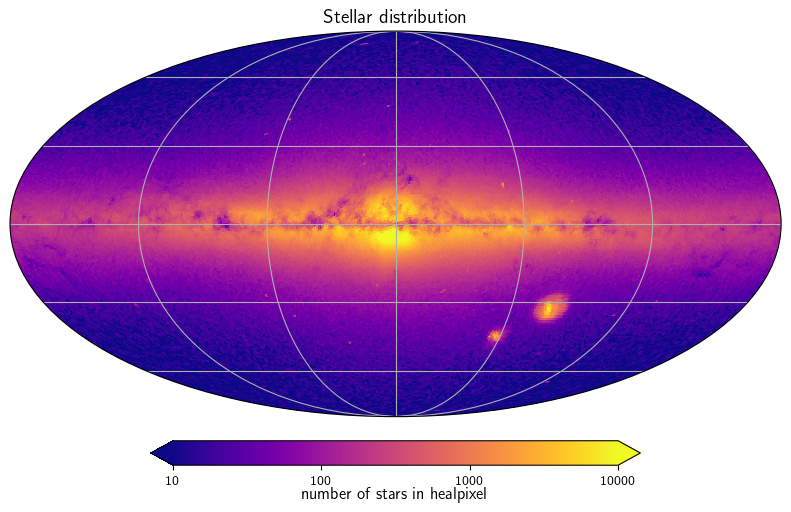

In [54]:
projview(map_stars, title=rf"Stellar distribution",
         unit=r"number of stars in healpixel", cmap=cmap_map, coord=['C', 'G'], 
         min=10, max=10000, norm='log', cbar_ticks=[10, 100, 1000, 10000],
         graticule=True)

fn = f'{plot_dir}/systematics_map_stars.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

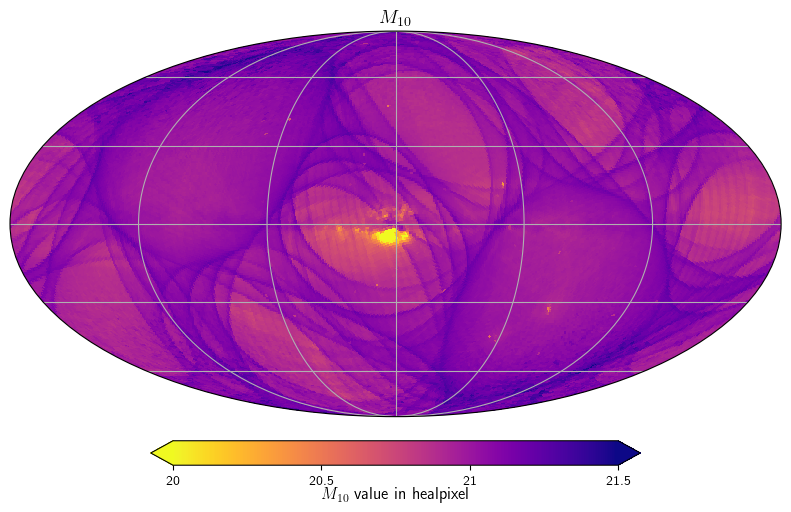

In [55]:
# reverse colormap bc high is worse here
projview(map_m10, title=r"$M_{10}$",
         unit=r"$M_{10}$ value in healpixel", cmap=cmap_map+'_r', coord=['C', 'G'],
         min=20.0, max=21.5, cbar_ticks=[20.0, 20.5, 21.0, 21.5],
         graticule=True)

fn = f'{plot_dir}/systematics_map_m10.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

# Catalog properties

### Sky distribution

In [56]:
map_gcatlo = get_ndens_map(tab_gcatlo['ra'], tab_gcatlo['dec'])

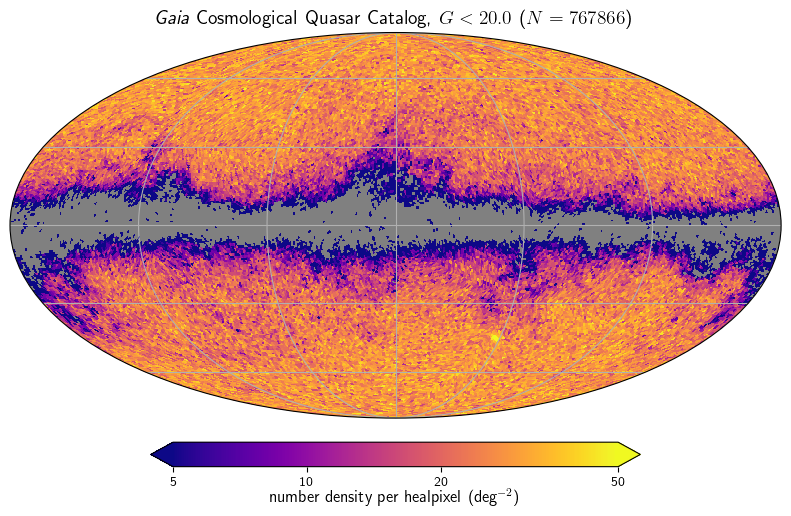

In [57]:
title_gcatlo = rf"{name_catalog}, $G<{G_lo}$ (N={len(tab_gcatlo):,})"
projview(map_gcatlo, title=title_gcatlo,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=50, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50])

fn = f'{plot_dir}/gcatlo_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [58]:
map_gcathi = get_ndens_map(tab_gcathi['ra'], tab_gcathi['dec'])

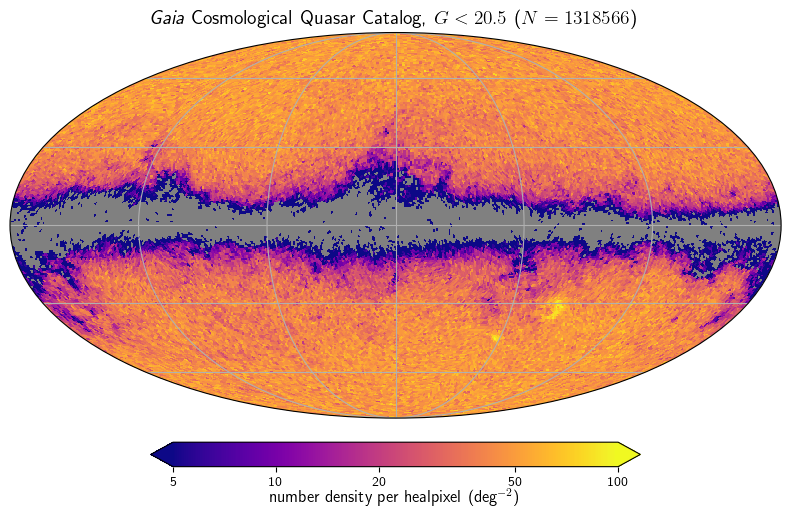

In [59]:
title_gcathi = rf"{name_catalog}, $G<{G_hi}$ (N={len(tab_gcathi):,})"
projview(map_gcathi, title=title_gcathi,
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=100, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50, 100])

fn = f'{plot_dir}/gcathi_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: see if can kill mcs with color or something; if not, cover w little circle masks

### Redshift distribution

GaiaQ, $z_\mathrm{SPZ}$
1318566
767866
1.446
GaiaQ, $z_\mathrm{\emph{Gaia}}$
1318566
767866
1.550
\emph{Gaia} candidates, $z_\mathrm{QSOC}$
6649162
1713913


/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


1.553
\emph{Gaia} purer, $z_\mathrm{QSOC}$
1942825
778054
1.550
SDSS Quasars $\times$ GaiaQ, $z_\mathrm{SDSS}$
245308
125539
1.721


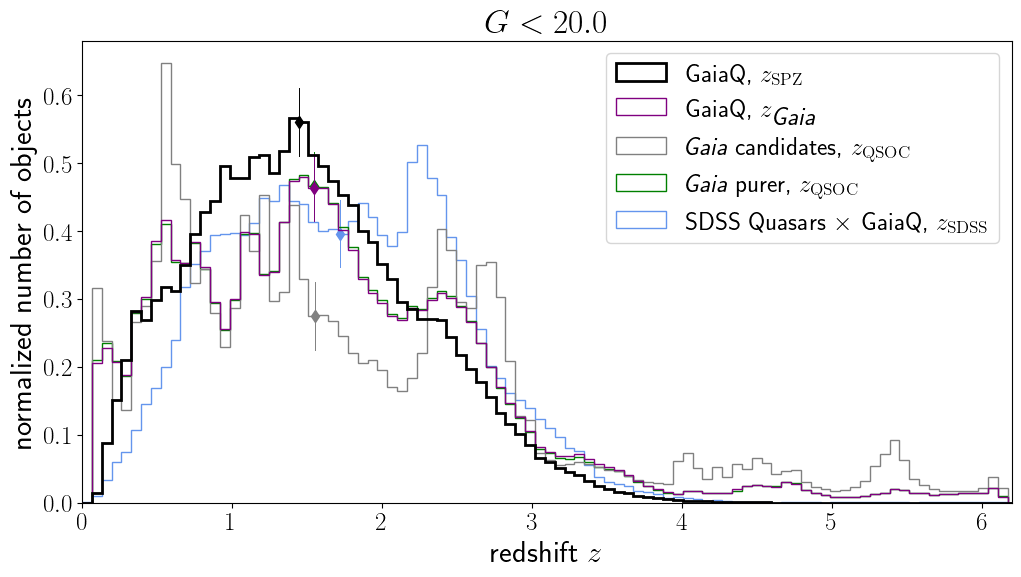

In [60]:
alpha = 1
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

tabs_znames = [(tab_gcathi, 'redshift_spz'),
              (tab_gcathi, 'redshift_qsoc'),
              (tab_gall, 'redshift_qsoc'),
              (tab_gpurer, 'redshift_qsoc'),
              (tab_spz_labeled, 'z_sdss')
             ]

labels = [r'GaiaQ, $z_\mathrm{SPZ}$',
          r'GaiaQ, $z_\mathrm{\emph{Gaia}}$',
          r'\emph{Gaia} candidates, $z_\mathrm{\emph{Gaia}}$',
          r'\emph{Gaia} purer, $z_\mathrm{\emph{Gaia}}$',
          r'SDSS Quasars $\times$ GaiaQ, $z_\mathrm{SDSS}$'
         ]

colors = ['black', color_gaia, 'grey', 'green', 'cornflowerblue']
lws = [2, 1, 1, 1, 1]
zorders = [5,4,3,2,1]

plt.figure(figsize=(12,6))
plt.title(rf"$G < {G_lo}$")

lw_med = 0.7
for ii in range(len(tabs_znames)):
    print(labels[ii])
    tab, z_name = tabs_znames[ii]
    print(len(tab))
    i_G = tab['phot_g_mean_mag'] < G_lo

    z_data = tab[i_G][z_name]
    i_finite = np.isfinite(z_data)
    z_data = z_data[i_finite]
    print(len(z_data))

    ns, bs, _ = plt.hist(z_data, bins=z_bins, alpha=alpha, color=colors[ii], lw=lws[ii], 
                 density=density, histtype=histtype, label=labels[ii], zorder=zorders[ii])
    
    z_med = np.median(z_data)
    # figure out where to plot median
    bb = np.digitize(z_med, bs)
    nval = ns[bb-1]
    plt.plot([z_med]*2, [nval-0.05, nval+0.05], lw=lw_med, color=colors[ii], zorder=zorders[ii])
    plt.plot(z_med, nval, marker='d', color=colors[ii], zorder=zorders[ii])
    print(f'{z_med:.3f}')

plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

plt.xlim(0,6.2)

fn = f'{plot_dir}/redshift_dists_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: does it makes sense that gaia purer and gaiaq qsoc redshifts are essentially the same?

A: discuss in paper; also about sdss dist being imprinted onto ours

### G distribution

GaiaQ, $G<20.5$
\emph{Gaia} candidates
\emph{Gaia} purer
SDSS Quasars $\times$ GaiaQ


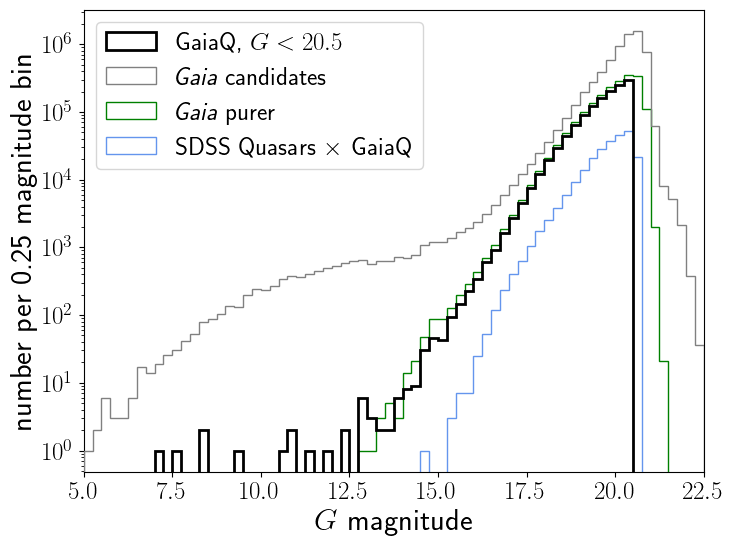

In [61]:
xlim = 5, 22.5
bin_width = 0.25
G_bins = np.arange(xlim[0], xlim[1]+bin_width, bin_width)

alpha = 1
density = False
histtype='step'

tabs = [tab_gcathi,
        tab_gall,
        tab_gpurer,
        tab_spz_labeled,
        ]

labels = [rf'GaiaQ, $G<{G_hi}$',
          r'\emph{Gaia} candidates',
          r'\emph{Gaia} purer',
          r'SDSS Quasars $\times$ GaiaQ'
         ]

colors = ['black', 'grey', 'green', 'cornflowerblue']
lws = [2, 1, 1, 1, 1]
zorders = [5,4,3,2,1]

plt.figure(figsize=(8,6))

lw_med = 0.7
for ii in range(len(tabs)):
    print(labels[ii])
    G_data = tabs[ii]['phot_g_mean_mag'] 
    i_finite = np.isfinite(G_data)
    G_data = G_data[i_finite]

    plt.hist(G_data, bins=G_bins, alpha=alpha, color=colors[ii], lw=lws[ii], 
                 density=density, histtype=histtype, label=labels[ii], zorder=zorders[ii])
    
plt.yscale('log')
plt.xlabel(r'$G$ magnitude')
plt.ylabel(f'number per {bin_width} magnitude bin')
plt.legend()

plt.xlim(xlim)

fn = f'{plot_dir}/G_dist.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: should the Gaia in GaiaQ be italicized?

TODO: should i keep sdss quasars on here? and should it be the intersection?

### Selection function map

TODO: update selection function map!

In [62]:
fn_sel = f"../data/maps/map_probability_dust_stars_m10_NSIDE{NSIDE}_G{G_lo}.fits"
map_sel = hp.read_map(fn_sel)

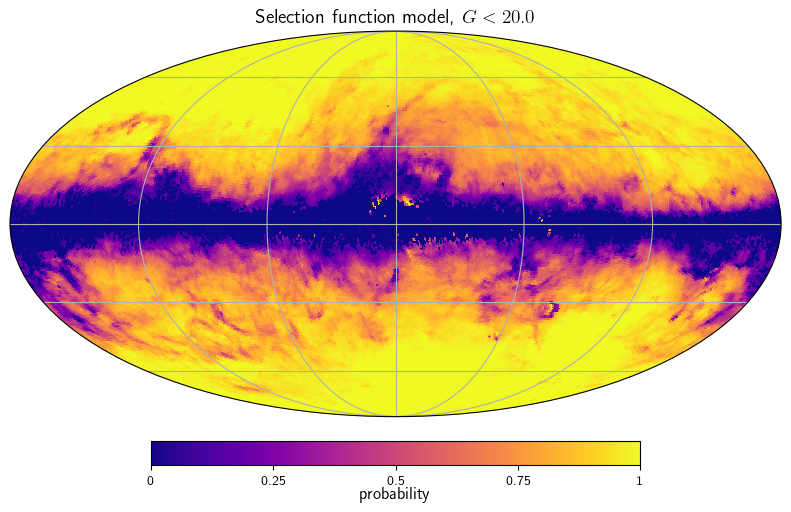

In [63]:
projview(map_sel, title=rf"Selection function model, $G<{G_lo}$",
            unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
            graticule=True, min=0, max=1, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
            ) 

fn = f'{plot_dir}/selection_function_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

In [64]:
fn_sel = f"../data/maps/map_probability_dust_stars_m10_NSIDE{NSIDE}_G{G_hi}.fits"
map_sel = hp.read_map(fn_sel)

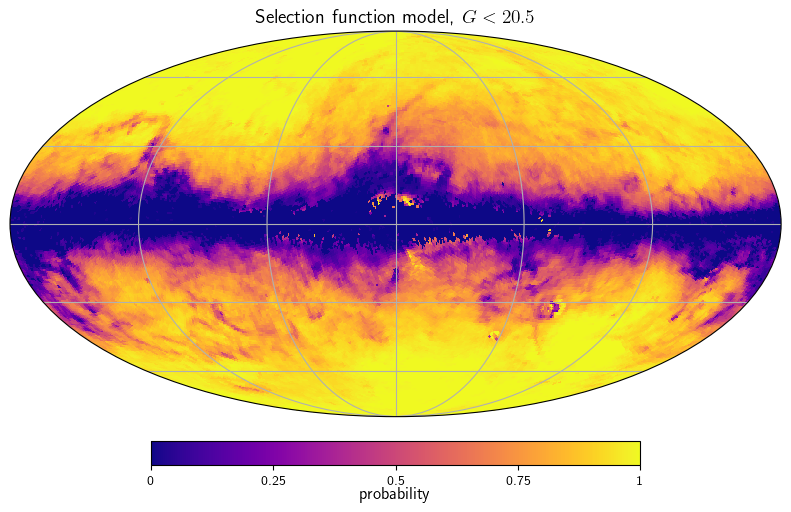

In [65]:
projview(map_sel, title=rf"Selection function model, $G<{G_hi}$",
            unit=r"probability", cmap=cmap_map, coord=['C', 'G'], 
            graticule=True, min=0, max=1, cbar_ticks=[0, 0.25, 0.5, 0.75, 1.0],
            ) 

fn = f'{plot_dir}/selection_function_Ghi.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

TODO: try sel func fitting while masking MCs

### Random catalog & residuals

In [66]:
fn_rand_Glo = f'../data/randoms/random_stardustm10_NSIDE64_G{G_lo}_10x.fits'
tab_rand_Glo = Table.read(fn_rand_Glo)
print(f"Number of random sources: {len(tab_rand_Glo)}")

Number of random sources: 7699241


In [67]:
map_rand_Glo = get_ndens_map(tab_rand_Glo['ra'], tab_rand_Glo['dec'])

Currently don't have random plot in the paper, just the residuals, but plot here as check

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


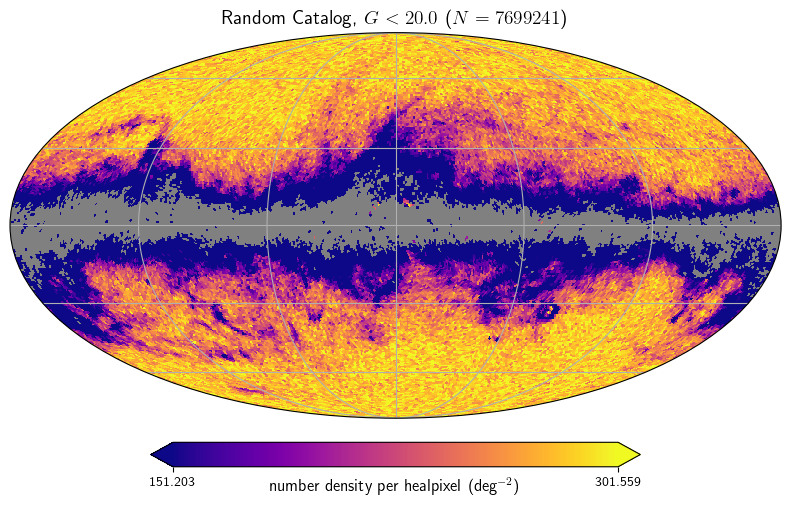

In [68]:
projview(map_rand_Glo, title=rf"Random Catalog, $G<{G_lo}$ (N={len(tab_rand_Glo):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=np.median(map_rand_Glo)-np.std(map_rand_Glo), max=np.median(map_rand_Glo)+np.std(map_rand_Glo), 
            norm='log', graticule=True,
            #show_tickmarkers=True
        )#, cbar_ticks=[5, 10, 20, 50, 100, 500, 1000]) 

Not totally clear what masking here is doing when subtract

Should show fractional? Not fair by plane, but fairer elsewhere?

In [69]:
norm_factor = len(tab_gcatlo)/len(tab_rand_Glo)
map_residuals_Glo = norm_factor*map_rand_Glo/map_gcatlo - 1

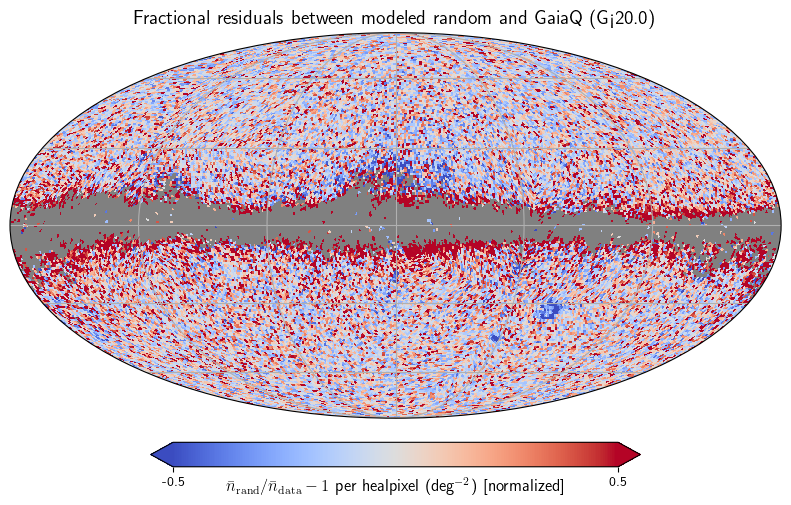

In [70]:
projview(map_residuals_Glo, title=rf"Fractional residuals between modeled random and {abbrv_catalog} $(G<{G_lo})$",
            unit=r"$\bar{n}_\mathrm{rand}/\bar{n}_\mathrm{data}-1$ per healpixel (deg$^{-2}$) [normalized]", cmap='coolwarm', coord=['C', 'G'], 
            min=-0.5, max=0.5, 
            graticule=True,
            #show_tickmarkers=True
            )#cbar_ticks=[5, 10, 20, 50, 100, 500, 1000]) 

fn = f'{plot_dir}/residuals_Glo.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

### Animation snapshot

In [71]:
#animate.make_anim(tab_gcathi, tab_gcathi['redshift_spz'], 0.12, 0.12, 2500, -28, -20)

In [72]:
GWuasar
GUNwise Quasars
Gaia Quasmology (Quasmo)
GCQC
GWQC

vol, z, bright, wise, gaia

SyntaxError: invalid syntax (3929665045.py, line 2)

G'NUFF quasars
Good&wise 
Quaia
Guys
Guise
Gise
wise-guys quasar skies